In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings
import os
from pathlib import Path
from pydub import AudioSegment

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/3533495058.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
import os
from pathlib import Path
import pandas as pd

# Define dataset path
dataset_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/")
train_path = dataset_path / "train_5sec"

# Function to traverse directories and map file information to labels
def traverse_and_map(directory, label):
    audio_files = []
    labels = []
    start_times = []
    end_times = []
    
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return pd.DataFrame()  # Return empty DataFrame if directory doesn't exist
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                # Prepend full dataset path to the file path
                audio_path = dataset_path / Path(root).relative_to(dataset_path) / file
                audio_files.append(str(audio_path))
                labels.append(label)
                start_times.append(0.0)  # Fixed start time
                end_times.append(5.0)   # Fixed end time

    # Create DataFrame for the current directory
    data = {
        "file": audio_files,
        "start_time": start_times,
        "end_time": end_times,
        "A": labels
    }
    return pd.DataFrame(data)

# Initialize a dictionary to hold DataFrames for each training size
labels_trains = {}

# Iterate over each train size folder
if train_path.exists():
    for train_size_dir in train_path.iterdir():
        if train_size_dir.is_dir():  # Ensure it's a directory
            training_size = train_size_dir.name  # Get the name of the training size directory

            # Process `pos` and `neg` subdirectories
            pos_dir = train_size_dir / "pos"
            neg_dir = train_size_dir / "neg"
            df_pos = traverse_and_map(pos_dir, 1)  # 1 for "pos" files
            df_neg = traverse_and_map(neg_dir, 0)  # 0 for "negative" files

            # Combine the DataFrames for `pos` and `neg`
            combined_df = pd.concat([df_pos, df_neg], ignore_index=True)

            # Set MultiIndex with 'file', 'start_time', and 'end_time'
            combined_df.set_index(["file", "start_time", "end_time"], inplace=True)

            # Rename the only column to "A"
            combined_df.columns = ['A']

            # Store the DataFrame in the dictionary
            labels_trains[training_size] = combined_df

            # Optionally, save each DataFrame to a CSV file
            output_path = dataset_path / f"labels_trains_{training_size}.csv"
            combined_df.to_csv(output_path)
            print(f"DataFrame saved for training size {training_size}: {output_path}")
else:
    print(f"Train path does not exist: {train_path}")

# Display the DataFrames for verification
for training_size, df in labels_trains.items():
    print(f"\nDataFrame for training size {training_size}:")
    print(df.head())


DataFrame saved for training size train_size_150: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/labels_trains_train_size_150.csv
DataFrame saved for training size train_size_25: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/labels_trains_train_size_25.csv
DataFrame saved for training size train_size_300: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/labels_trains_train_size_300.csv
DataFrame saved for training size train_size_275: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/labels_trains_train_size_275.csv
DataFrame saved for training size train_size_250: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/labels_trains_train_size_250.csv
DataFrame saved for training size train_size_175: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/labels_trains_train_size_175.csv
DataFrame saved for training size train_size_75: /Users/yifeitao/D

Processing data for training set

In [4]:
labels_trains['train_size_150'].head(20)

,,,A
file,start_time,end_time,
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_688.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_677.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_663.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_313.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_307.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_267.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_273.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_703.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_717.wav,0.0,5.0,1


Prepare audio Data

Step 1: Train shallow classifier on Perch embeddings

In [107]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


Step 2: Generate embeddings on the training and validation data

Training size 25

In [108]:
emb_train_25 = model.embed(labels_trains['train_size_25'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [111]:
csv_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test_5sec/test_dataset_5sec.csv")
audio_file_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test_5sec/test_dataset_5sec.wav")
output_folder = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test_5sec/clips")
output_csv_dir = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test_5sec/")
output_csv = output_csv_dir / "processed_test_dataset_5sec.csv"

# Ensure the output directories exist
output_folder.mkdir(parents=True, exist_ok=True)
output_csv_dir.mkdir(parents=True, exist_ok=True)

# Read the CSV file
df_csv = pd.read_csv(csv_path)

# Determine label based on conditions
df_csv["A"] = df_csv.apply(
    lambda row: 1 if row["label"] == 1 and row["Annotation"] == "BULLFROG" else 0, axis=1
)

# Load the audio file
audio = AudioSegment.from_file(audio_file_path)

# Initialize lists for DataFrame creation
file_paths = []
start_times = []
end_times = []
labels = []

# Partition the audio file into 5-second clips based on CSV
for index, row in df_csv.iterrows():
    start_time = index * 5 * 1000  # in milliseconds
    end_time = start_time + 5 * 1000  # 3 seconds later

    # Extract clip
    clip = audio[start_time:end_time]

    # Save clip to the output folder
    #WT does not have unique row identifier filename column
    filename = row["filename"]
    clip_path = output_folder / filename
    clip.export(clip_path, format="wav")

    # Add details to lists
    file_paths.append(str(clip_path))
    start_times.append(0.0)  
    end_times.append(5.0)  
    labels.append(row["A"])

# Create the DataFrame
df_processed = pd.DataFrame({
    "file": file_paths,
    "start_time": start_times,
    "end_time": end_times,
    "A": labels
})
df_processed.set_index(["file", "start_time", "end_time"], inplace=True)
df_processed.columns = ['A']
# Save the DataFrame to a CSV file
df_processed.to_csv(output_csv, index=False)

print(f"Processed dataset saved to {output_csv}")
print(f"Audio clips saved to {output_folder}")
print(df_processed.head())

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/3435153001.py:20: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test_5sec/test_dataset_5sec.wav'>
  audio = AudioSegment.from_file(audio_file_path)
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/3435153001.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test_5sec/clips/t-11113588_749.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/3435153001.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test_5sec/clips/t-11113588_216.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/3435153001.py:40: ResourceWarning: unclosed file <_io.Buffer

Processed dataset saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test_5sec/processed_test_dataset_5sec.csv
Audio clips saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test_5sec/clips
                                                                        A
file                                               start_time end_time   
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0


In [112]:
labels_val = df_processed

In [113]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [114]:
emb_train_25 = torch.tensor(emb_train_25, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_25.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_25 = emb_train_25.view(emb_train_25.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_25: {emb_train_25.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([50, 512])
Reshaped emb_train_25: torch.Size([50, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [115]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [116]:
emb_train_25 = emb_train_25.repeat(1, 3, 1, 1)  # Duplicate to 3 channels
emb_val = emb_val.repeat(1, 3, 1, 1)

In [117]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [118]:
quick_fit(model.network, emb_train_25, labels_trains['train_size_25'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 9.235466859536245e-05, Val Loss: 0.6107286810874939
val AU ROC: 0.944
val MAP: 0.944
Epoch 200/1000, Loss: 5.1161212468286976e-05, Val Loss: 0.6433252692222595
val AU ROC: 0.946
val MAP: 0.946
Epoch 300/1000, Loss: 3.312354601803236e-05, Val Loss: 0.6647472977638245
val AU ROC: 0.946
val MAP: 0.946
Epoch 400/1000, Loss: 2.346650217077695e-05, Val Loss: 0.6806093454360962
val AU ROC: 0.947
val MAP: 0.947
Epoch 500/1000, Loss: 1.7578573533683084e-05, Val Loss: 0.6952250003814697
val AU ROC: 0.947
val MAP: 0.947
Epoch 600/1000, Loss: 1.3638862583320588e-05, Val Loss: 0.7068679928779602
val AU ROC: 0.947
val MAP: 0.947
Epoch 700/1000, Loss: 1.0901965652010404e-05, Val Loss: 0.7166054248809814
val AU ROC: 0.948
val MAP: 0.948
Epoch 800/1000, Loss: 8.940275620261673e-06, Val Loss: 0.7252063155174255
val AU ROC: 0.948
val MAP: 0.948
Epoch 900/1000, Loss: 7.455596914951457e-06, Val Loss: 0.73307204246521
val AU ROC: 0.948
val MAP: 0.948
Epoch 1000/1000, Loss: 6.3006782511

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/1842857064.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9511111111111111

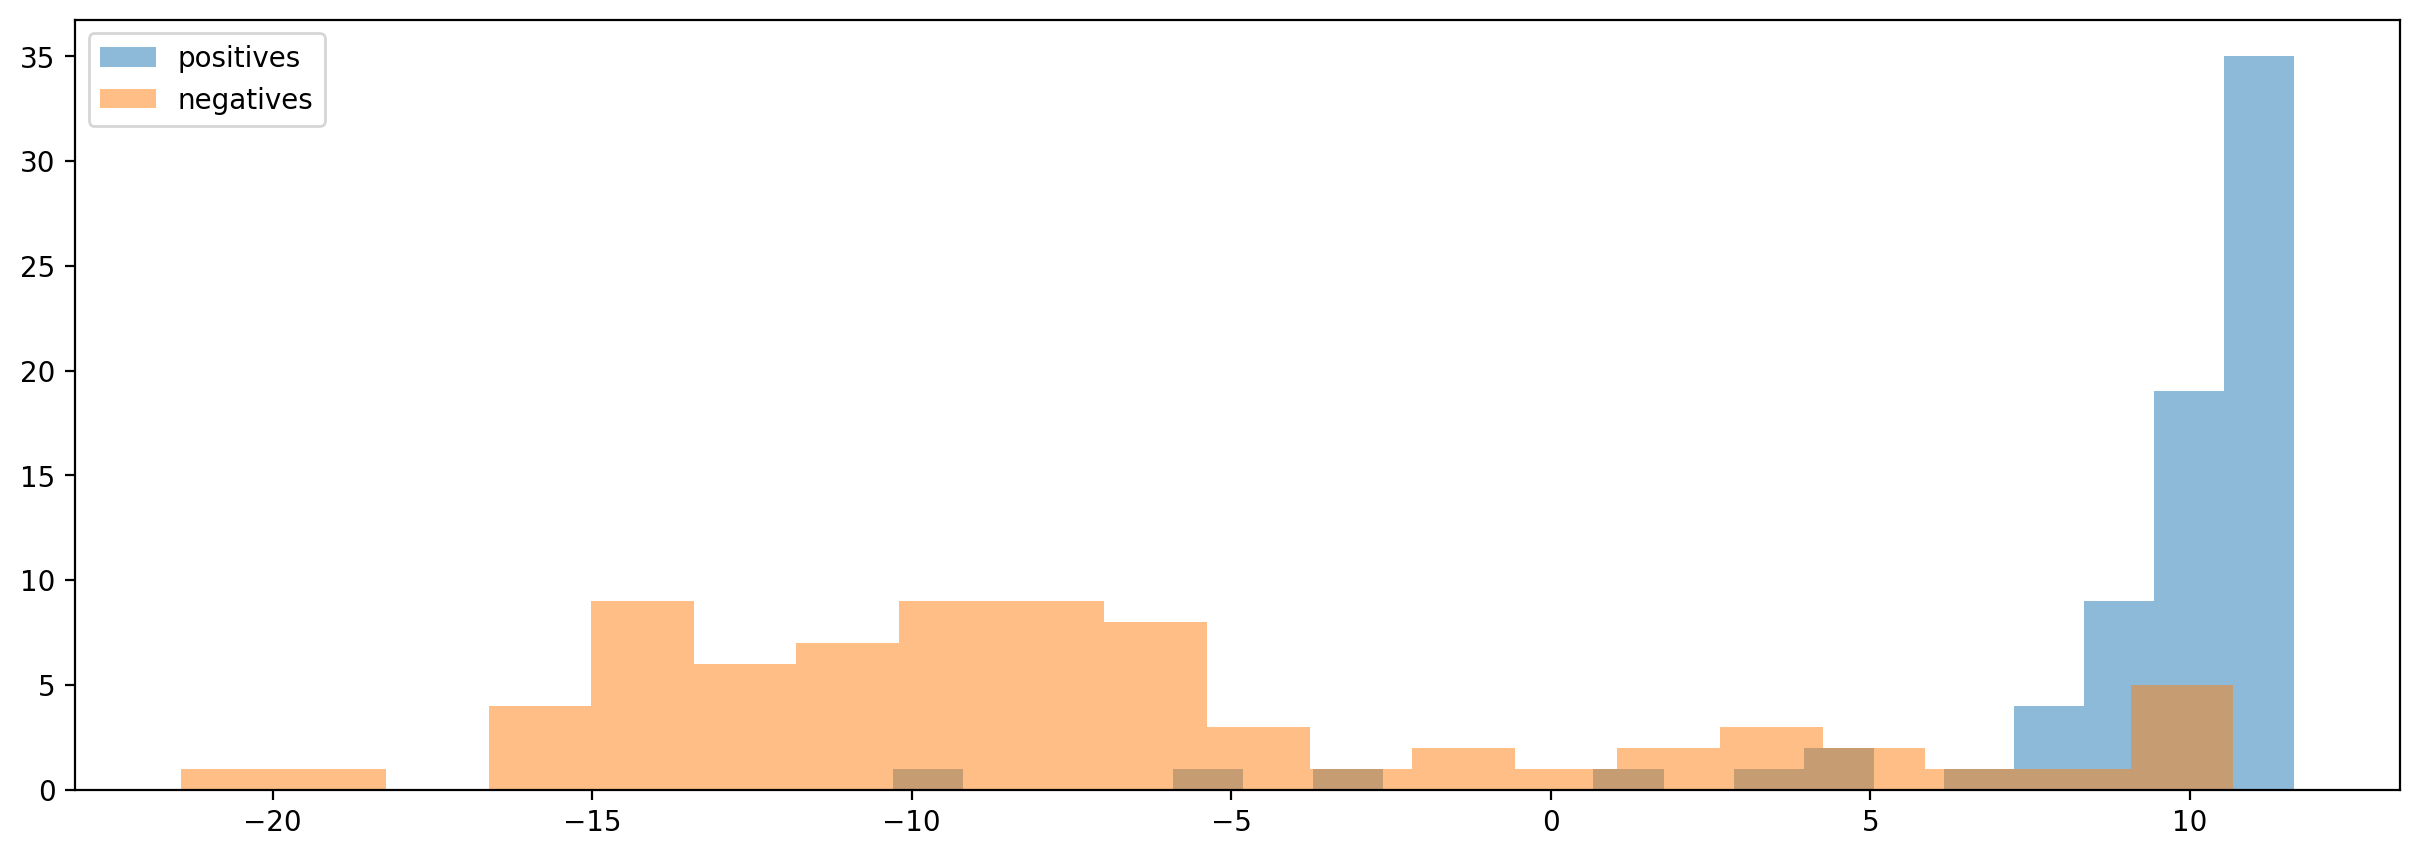

In [119]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_25 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_25

Training size 50

In [127]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [128]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [129]:
emb_train_50 = model.embed(labels_trains['train_size_50'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [130]:
emb_train_50 = torch.tensor(emb_train_50, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_50.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_50 = emb_train_50.view(emb_train_50.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_50: {emb_train_50.shape}")

Original shape of emb_train: torch.Size([100, 512])
Reshaped emb_train_50: torch.Size([100, 1, 32, 16])


In [131]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [132]:
emb_train_50 = emb_train_50.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [133]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [134]:
quick_fit(model.network, emb_train_50, labels_trains['train_size_50'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 8.431138121522963e-05, Val Loss: 0.6257013082504272
val AU ROC: 0.930
val MAP: 0.930
Epoch 200/1000, Loss: 4.333295873948373e-05, Val Loss: 0.6780421733856201
val AU ROC: 0.930
val MAP: 0.930
Epoch 300/1000, Loss: 2.7733034585253336e-05, Val Loss: 0.7087114453315735
val AU ROC: 0.931
val MAP: 0.931
Epoch 400/1000, Loss: 1.950268415384926e-05, Val Loss: 0.7326143383979797
val AU ROC: 0.931
val MAP: 0.931
Epoch 500/1000, Loss: 1.4540511074301321e-05, Val Loss: 0.7529321312904358
val AU ROC: 0.932
val MAP: 0.932
Epoch 600/1000, Loss: 1.1279820682830177e-05, Val Loss: 0.7711789011955261
val AU ROC: 0.932
val MAP: 0.932
Epoch 700/1000, Loss: 9.017354386742227e-06, Val Loss: 0.787585437297821
val AU ROC: 0.932
val MAP: 0.932
Epoch 800/1000, Loss: 7.3782507570285816e-06, Val Loss: 0.8029561638832092
val AU ROC: 0.932
val MAP: 0.932
Epoch 900/1000, Loss: 6.149868568172678e-06, Val Loss: 0.8170018196105957
val AU ROC: 0.933
val MAP: 0.933
Epoch 1000/1000, Loss: 5.202881766

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/2687331274.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9480888888888889

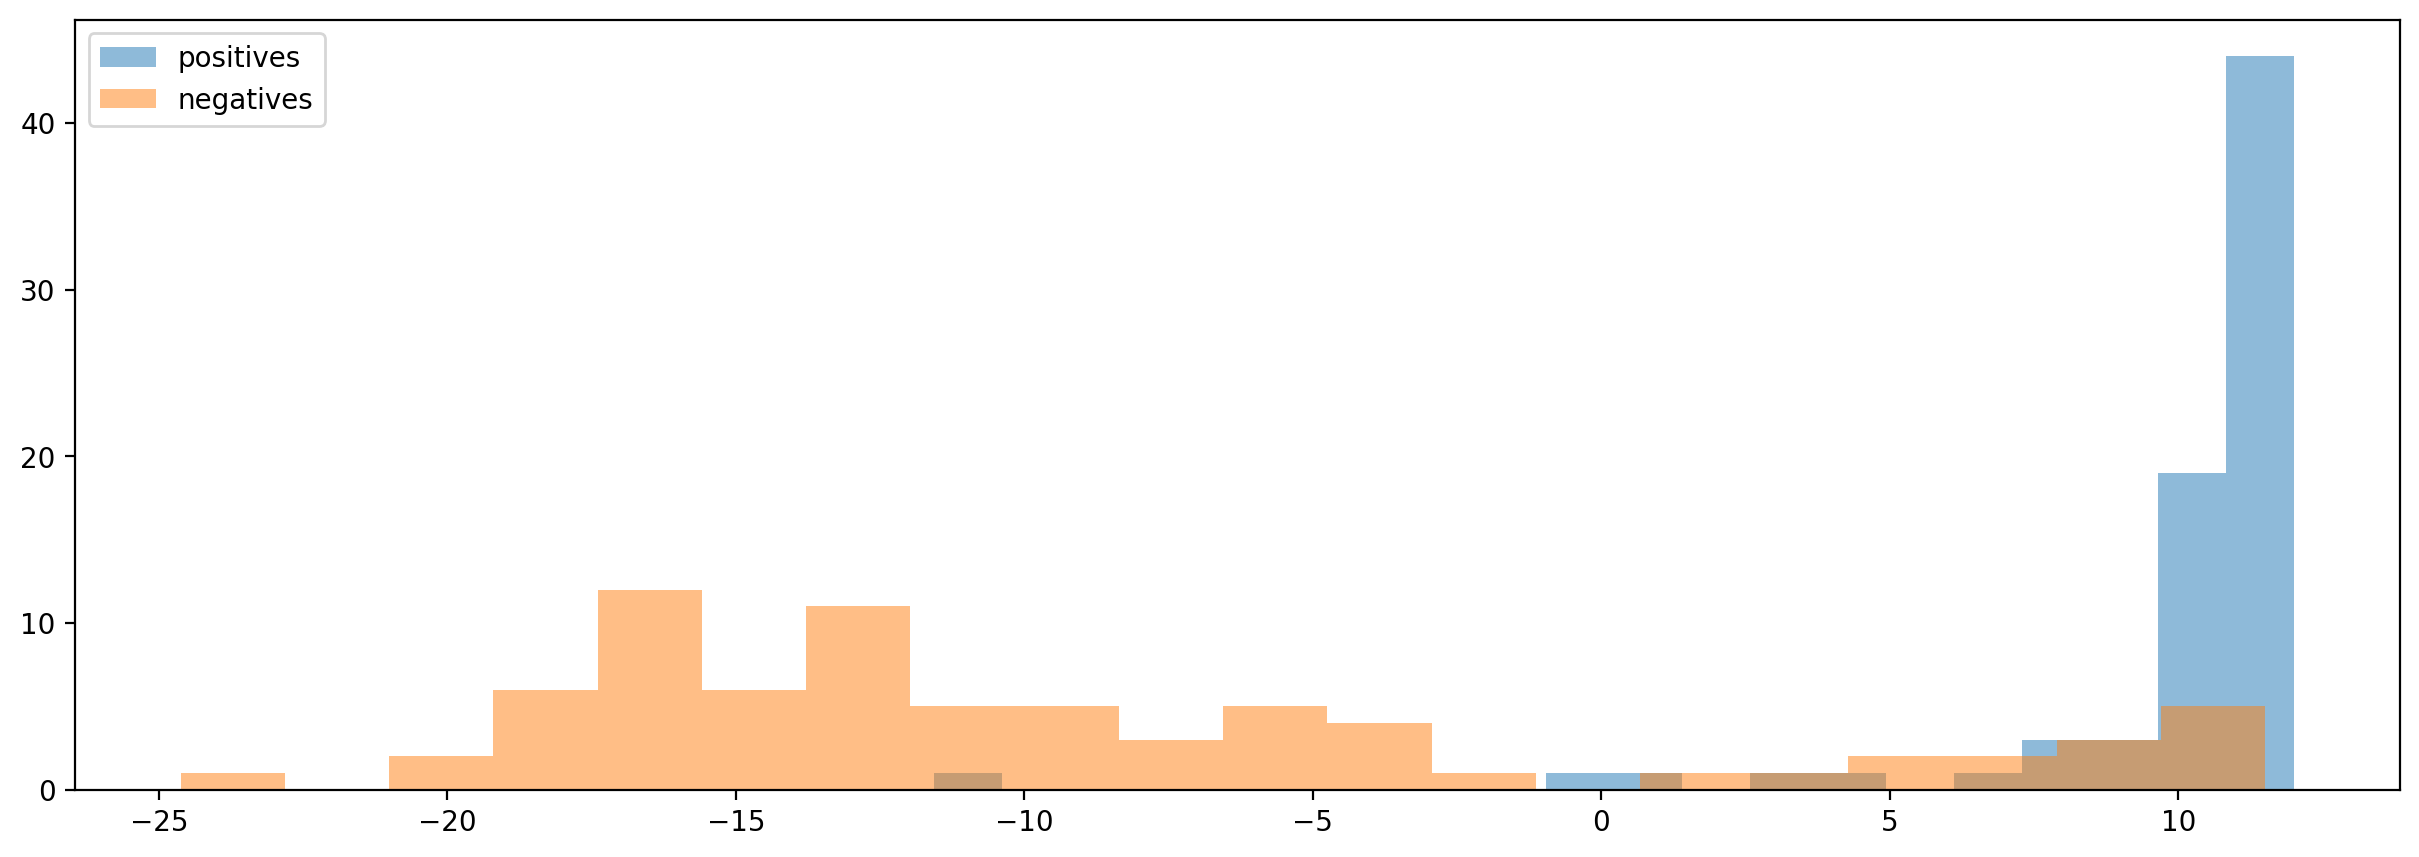

In [135]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_50 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_50

Training size 75

In [136]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [137]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [138]:
emb_train_75 = model.embed(labels_trains['train_size_75'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [139]:
emb_train_75 = torch.tensor(emb_train_75, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_75.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_75 = emb_train_75.view(emb_train_75.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_75: {emb_train_75.shape}")

Original shape of emb_train: torch.Size([150, 512])
Reshaped emb_train_75: torch.Size([150, 1, 32, 16])


In [140]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [141]:
emb_train_75 = emb_train_75.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [142]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [143]:
quick_fit(model.network, emb_train_75, labels_trains['train_size_75'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 6.519085582112893e-05, Val Loss: 0.8347110152244568
val AU ROC: 0.950
val MAP: 0.950
Epoch 200/1000, Loss: 4.1291543311672285e-05, Val Loss: 0.8661409616470337
val AU ROC: 0.948
val MAP: 0.948
Epoch 300/1000, Loss: 2.9780727345496416e-05, Val Loss: 0.8899924755096436
val AU ROC: 0.948
val MAP: 0.948
Epoch 400/1000, Loss: 2.245293762825895e-05, Val Loss: 0.9088926911354065
val AU ROC: 0.948
val MAP: 0.948
Epoch 500/1000, Loss: 1.7502552509540692e-05, Val Loss: 0.9257490038871765
val AU ROC: 0.947
val MAP: 0.947
Epoch 600/1000, Loss: 1.4023023140907753e-05, Val Loss: 0.9409478902816772
val AU ROC: 0.946
val MAP: 0.946
Epoch 700/1000, Loss: 1.1474220627860632e-05, Val Loss: 0.9534362554550171
val AU ROC: 0.946
val MAP: 0.946
Epoch 800/1000, Loss: 9.542825864627957e-06, Val Loss: 0.9646254181861877
val AU ROC: 0.946
val MAP: 0.946
Epoch 900/1000, Loss: 8.06254320195876e-06, Val Loss: 0.9743449687957764
val AU ROC: 0.944
val MAP: 0.944
Epoch 1000/1000, Loss: 6.85507347

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/4227207383.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9415111111111111

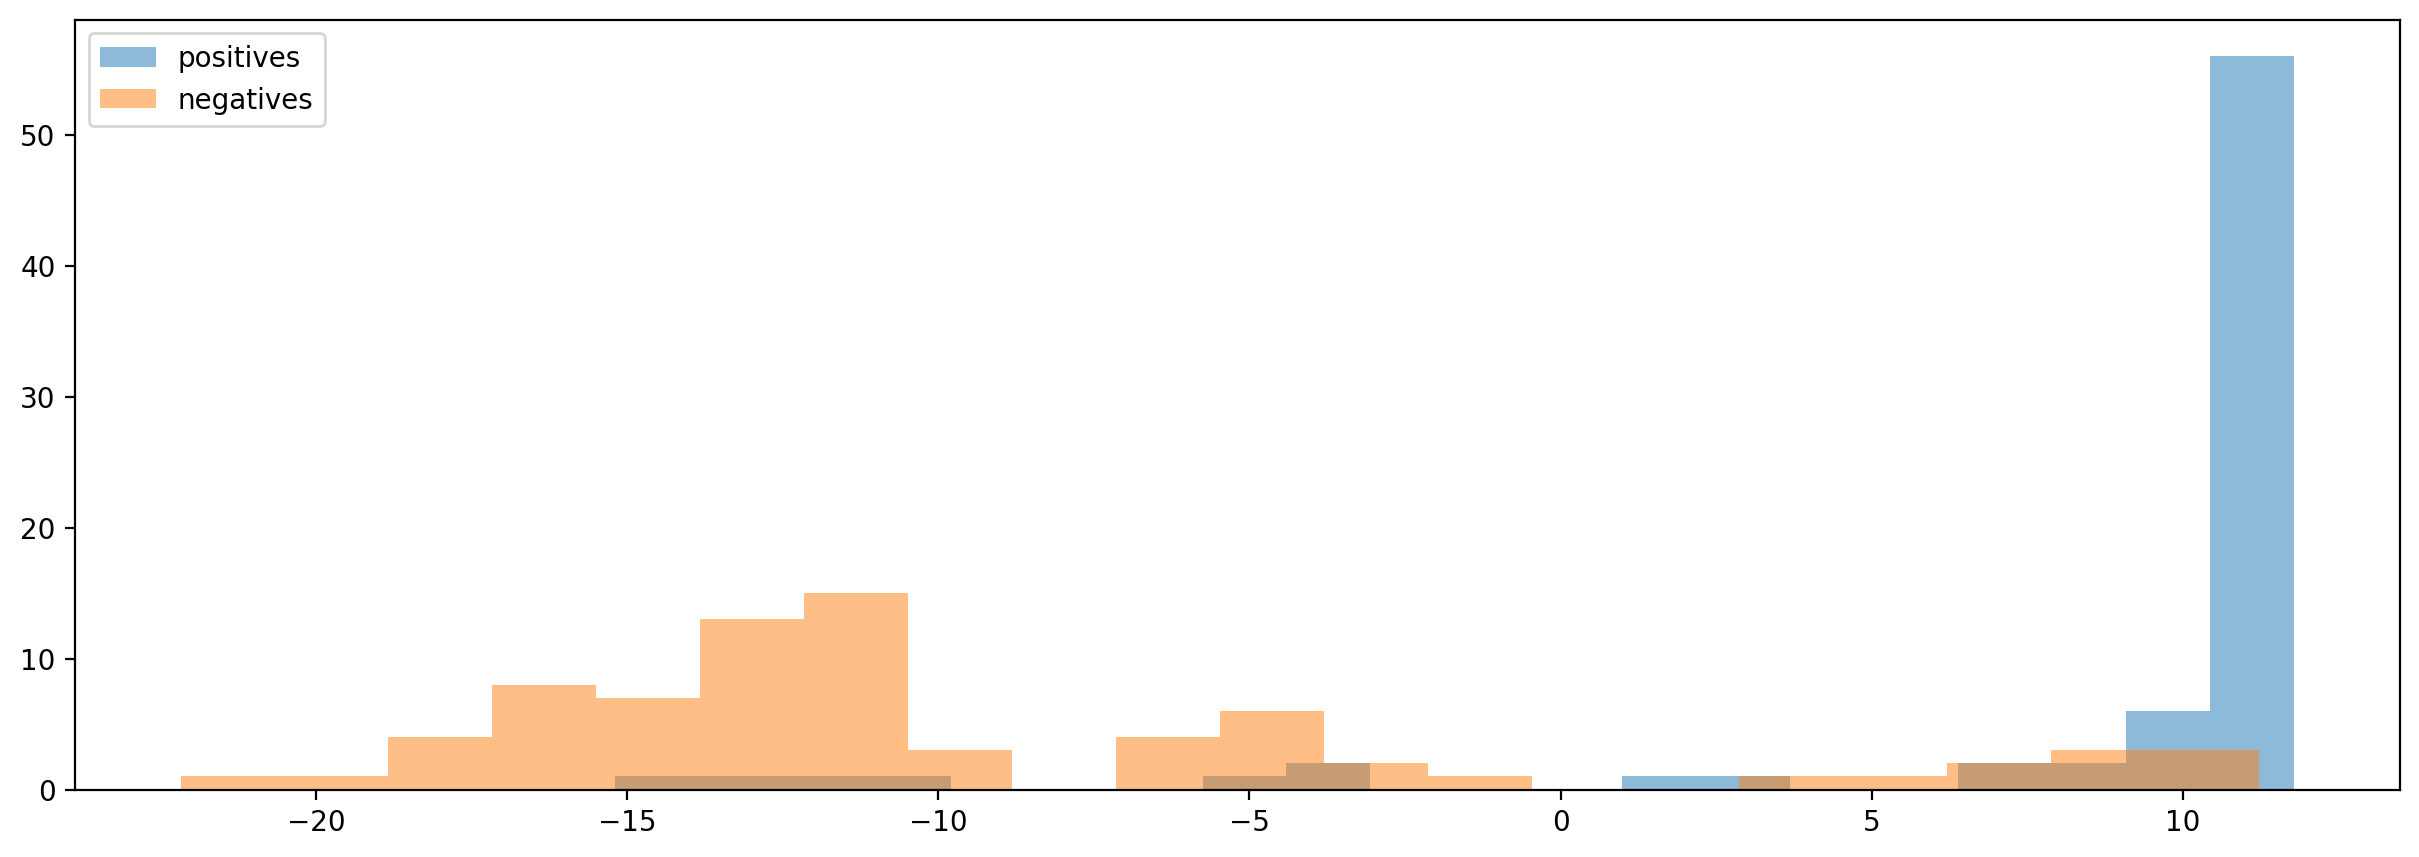

In [144]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_75 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_75

Training size 100

In [145]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [146]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [147]:
emb_train_100 = model.embed(labels_trains['train_size_100'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [148]:
emb_train_100 = torch.tensor(emb_train_100, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_100.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_100 = emb_train_100.view(emb_train_100.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)
# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_100.shape}")

Original shape of emb_train: torch.Size([200, 512])
Reshaped emb_train_100: torch.Size([200, 1, 32, 16])


In [149]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [150]:
emb_train_100 = emb_train_100.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [151]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [152]:
quick_fit(model.network, emb_train_100, labels_trains['train_size_100'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 8.876397623680532e-05, Val Loss: 0.6437920928001404
val AU ROC: 0.923
val MAP: 0.923
Epoch 200/1000, Loss: 5.303593206917867e-05, Val Loss: 0.6611268520355225
val AU ROC: 0.921
val MAP: 0.921
Epoch 300/1000, Loss: 3.6149351217318326e-05, Val Loss: 0.6735242605209351
val AU ROC: 0.919
val MAP: 0.919
Epoch 400/1000, Loss: 2.6277199140167795e-05, Val Loss: 0.6805878281593323
val AU ROC: 0.919
val MAP: 0.919
Epoch 500/1000, Loss: 2.0019358998979442e-05, Val Loss: 0.6857601404190063
val AU ROC: 0.917
val MAP: 0.917
Epoch 600/1000, Loss: 1.5804402210051194e-05, Val Loss: 0.6899166107177734
val AU ROC: 0.916
val MAP: 0.916
Epoch 700/1000, Loss: 1.2760495337715838e-05, Val Loss: 0.694214940071106
val AU ROC: 0.917
val MAP: 0.917
Epoch 800/1000, Loss: 1.0539558388700243e-05, Val Loss: 0.697883665561676
val AU ROC: 0.915
val MAP: 0.915
Epoch 900/1000, Loss: 8.840233931550756e-06, Val Loss: 0.702643096446991
val AU ROC: 0.915
val MAP: 0.915
Epoch 1000/1000, Loss: 7.514301159

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/1406550891.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9411555555555556

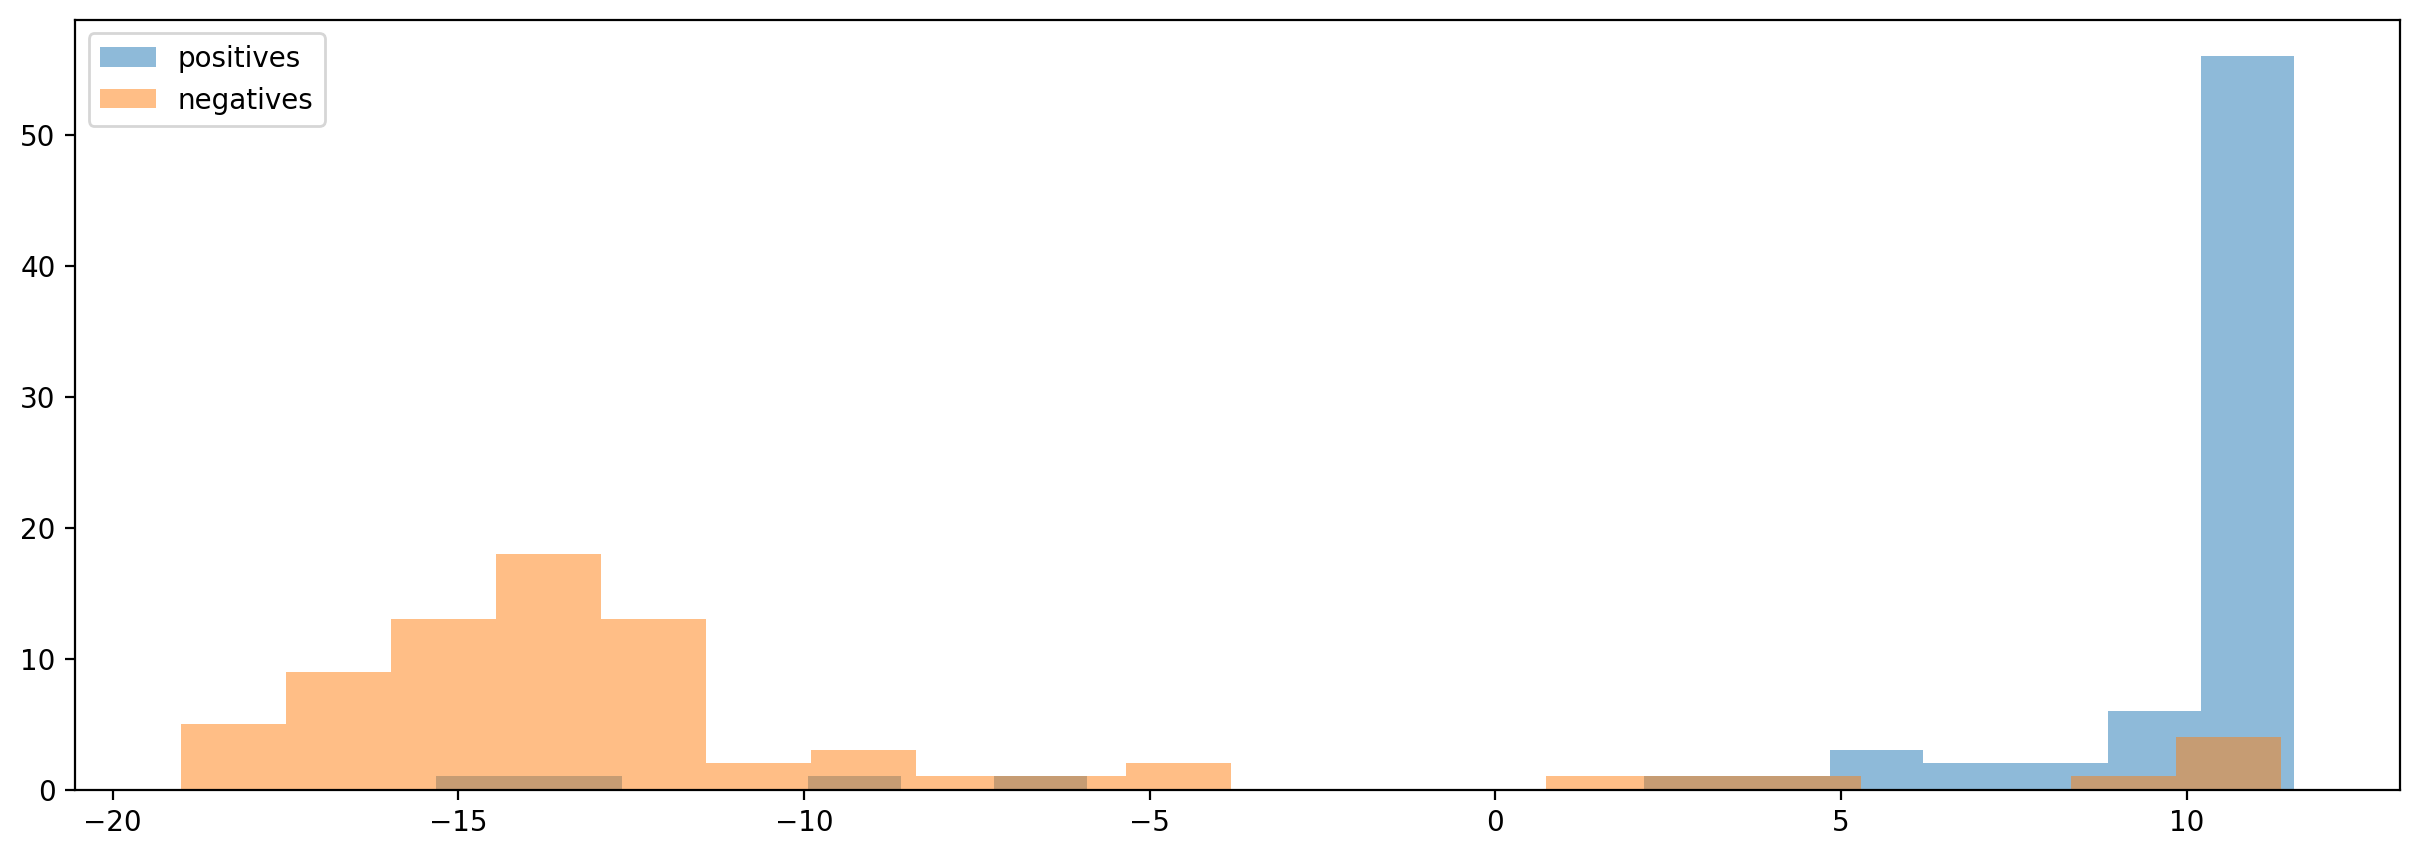

In [153]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_100 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_100

Training size 125

In [154]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [155]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [156]:
emb_train_125 = model.embed(labels_trains['train_size_125'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [157]:
emb_train_125 = torch.tensor(emb_train_125, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_125.shape}")

height, width = 32, 16  # Ensure height * width = 512
emb_train_125 = emb_train_125.view(emb_train_125.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)
# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_125.shape}")

Original shape of emb_train: torch.Size([250, 512])
Reshaped emb_train_100: torch.Size([250, 1, 32, 16])


In [158]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [159]:
emb_train_125 = emb_train_125.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [160]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [161]:
quick_fit(model.network, emb_train_125, labels_trains['train_size_125'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 8.613241516286507e-05, Val Loss: 0.45903074741363525
val AU ROC: 0.973
val MAP: 0.973
Epoch 200/1000, Loss: 5.0911097787320614e-05, Val Loss: 0.4807708263397217
val AU ROC: 0.972
val MAP: 0.972
Epoch 300/1000, Loss: 3.4658427466638386e-05, Val Loss: 0.4962227940559387
val AU ROC: 0.972
val MAP: 0.972
Epoch 400/1000, Loss: 2.5168097636196762e-05, Val Loss: 0.5095674395561218
val AU ROC: 0.971
val MAP: 0.971
Epoch 500/1000, Loss: 1.9132268789689988e-05, Val Loss: 0.5201443433761597
val AU ROC: 0.971
val MAP: 0.971
Epoch 600/1000, Loss: 1.5009820344857872e-05, Val Loss: 0.5291951894760132
val AU ROC: 0.971
val MAP: 0.971
Epoch 700/1000, Loss: 1.210720893141115e-05, Val Loss: 0.5399155616760254
val AU ROC: 0.971
val MAP: 0.971
Epoch 800/1000, Loss: 9.992400919145439e-06, Val Loss: 0.5499950647354126
val AU ROC: 0.971
val MAP: 0.971
Epoch 900/1000, Loss: 8.384414286410902e-06, Val Loss: 0.5590219497680664
val AU ROC: 0.970
val MAP: 0.970
Epoch 1000/1000, Loss: 7.135936

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/3376882458.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9715555555555556

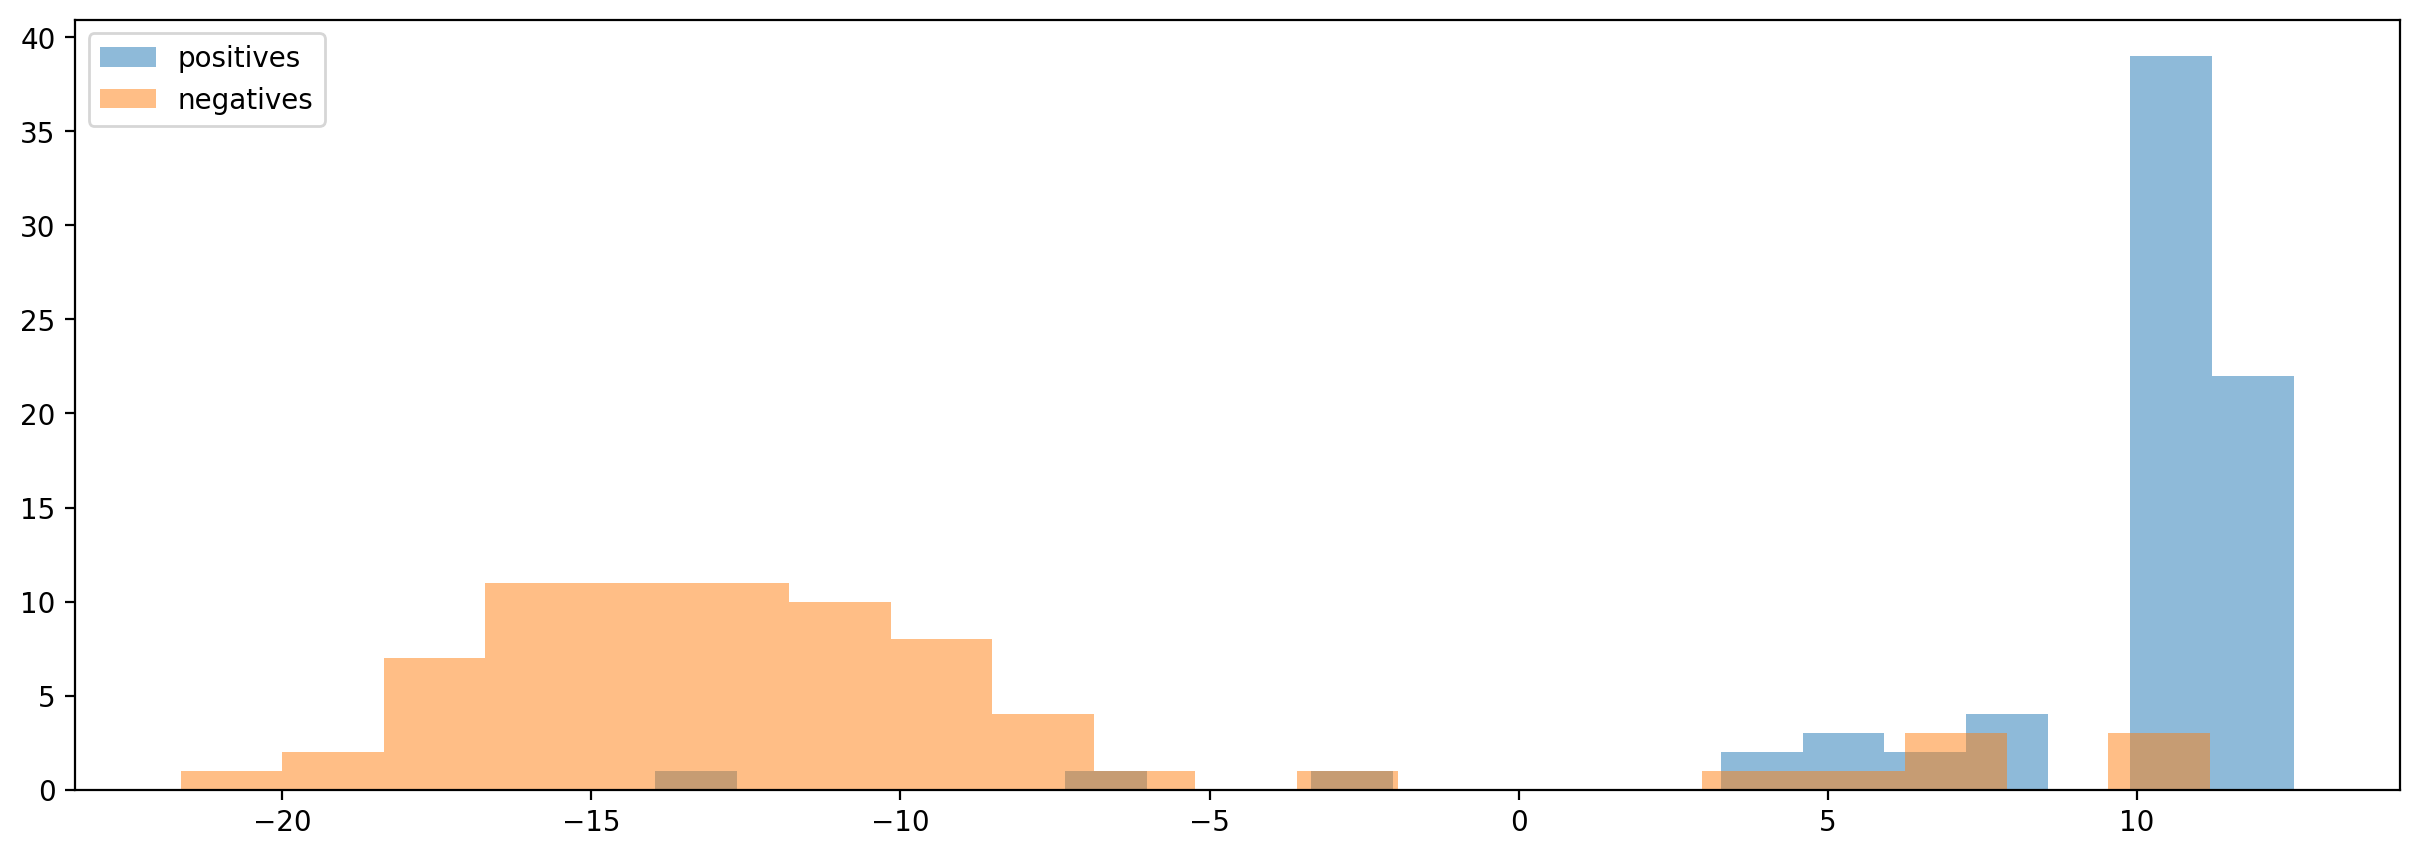

In [162]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_125 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_125

Training size 150

In [163]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [164]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [165]:
emb_train_150 = model.embed(labels_trains['train_size_150'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [166]:
emb_train_150 = torch.tensor(emb_train_150, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_150.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_150 = emb_train_150.view(emb_train_150.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_150: {emb_train_150.shape}")

Original shape of emb_train: torch.Size([300, 512])
Reshaped emb_train_150: torch.Size([300, 1, 32, 16])


In [167]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [168]:
emb_train_150 = emb_train_150.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [169]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [170]:
quick_fit(model.network, emb_train_150, labels_trains['train_size_150'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 7.602280675200745e-05, Val Loss: 0.4851326048374176
val AU ROC: 0.943
val MAP: 0.943
Epoch 200/1000, Loss: 4.3288731831125915e-05, Val Loss: 0.5334959626197815
val AU ROC: 0.933
val MAP: 0.933
Epoch 300/1000, Loss: 3.0349765438586473e-05, Val Loss: 0.5627009868621826
val AU ROC: 0.930
val MAP: 0.930
Epoch 400/1000, Loss: 2.2450622054748237e-05, Val Loss: 0.609450101852417
val AU ROC: 0.928
val MAP: 0.928
Epoch 500/1000, Loss: 1.736584999889601e-05, Val Loss: 0.6237249970436096
val AU ROC: 0.923
val MAP: 0.923
Epoch 600/1000, Loss: 1.3858194506610744e-05, Val Loss: 0.6422704458236694
val AU ROC: 0.918
val MAP: 0.918
Epoch 700/1000, Loss: 1.1065151738876011e-05, Val Loss: 0.6480135321617126
val AU ROC: 0.922
val MAP: 0.922
Epoch 800/1000, Loss: 9.122532901528757e-06, Val Loss: 0.6591458916664124
val AU ROC: 0.923
val MAP: 0.923
Epoch 900/1000, Loss: 7.66110224503791e-06, Val Loss: 0.6624330878257751
val AU ROC: 0.925
val MAP: 0.925
Epoch 1000/1000, Loss: 6.535943612

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/1953958238.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9511111111111111

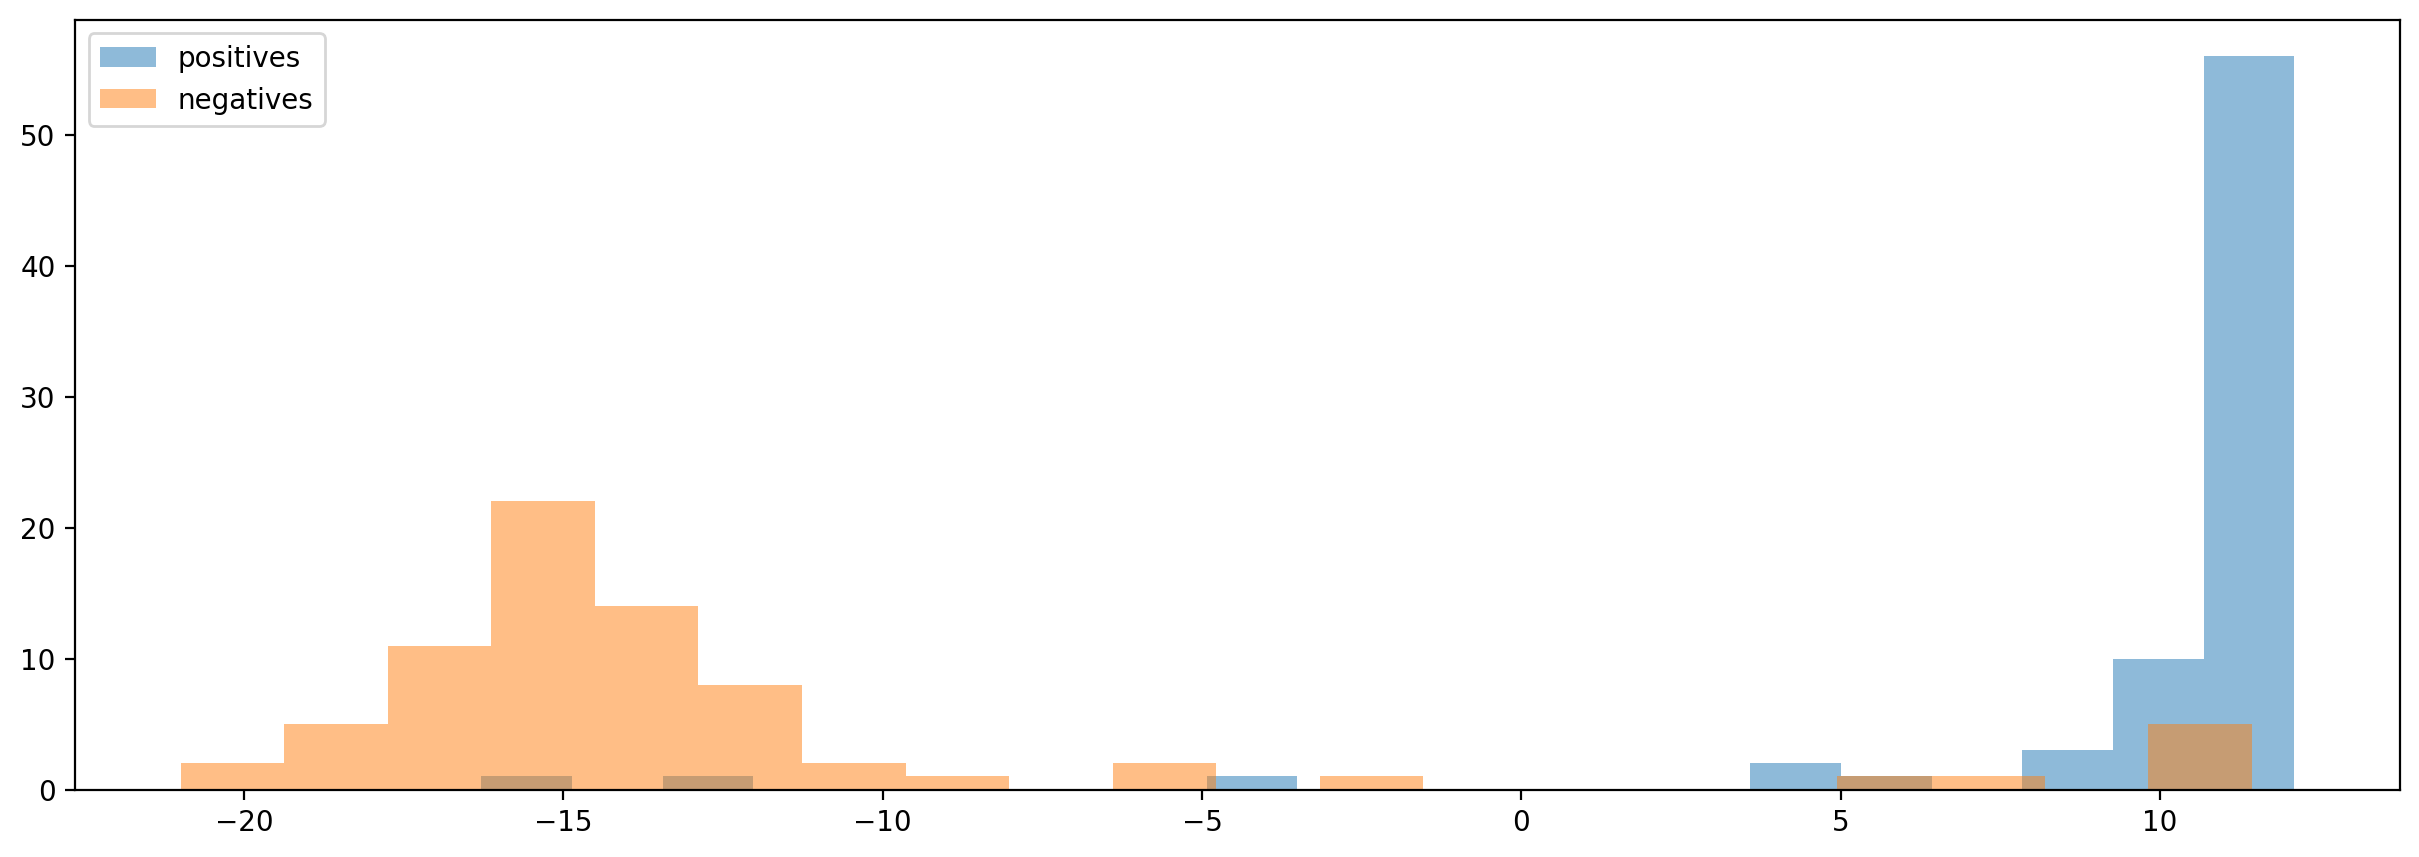

In [171]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_150 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_150

Training size 175

In [172]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [173]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [174]:
emb_train_175 = model.embed(labels_trains['train_size_175'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/11 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [175]:
emb_train_175 = torch.tensor(emb_train_175, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_175.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_175 = emb_train_175.view(emb_train_175.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_175: {emb_train_175.shape}")

Original shape of emb_train: torch.Size([350, 512])
Reshaped emb_train_175: torch.Size([350, 1, 32, 16])


In [176]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [177]:
emb_train_175 = emb_train_175.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [178]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [179]:
quick_fit(model.network, emb_train_175, labels_trains['train_size_175'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 7.373598782578483e-05, Val Loss: 0.6557248830795288
val AU ROC: 0.960
val MAP: 0.960
Epoch 200/1000, Loss: 3.971312617068179e-05, Val Loss: 0.6945893168449402
val AU ROC: 0.964
val MAP: 0.964
Epoch 300/1000, Loss: 2.5605058908695355e-05, Val Loss: 0.723893404006958
val AU ROC: 0.965
val MAP: 0.965
Epoch 400/1000, Loss: 1.7995305825024843e-05, Val Loss: 0.7431397438049316
val AU ROC: 0.965
val MAP: 0.965
Epoch 500/1000, Loss: 1.3333674360183068e-05, Val Loss: 0.752930223941803
val AU ROC: 0.967
val MAP: 0.967
Epoch 600/1000, Loss: 1.0343987923988607e-05, Val Loss: 0.7678213715553284
val AU ROC: 0.967
val MAP: 0.967
Epoch 700/1000, Loss: 8.290370715258177e-06, Val Loss: 0.7801258563995361
val AU ROC: 0.967
val MAP: 0.967
Epoch 800/1000, Loss: 6.782757282053353e-06, Val Loss: 0.7893125414848328
val AU ROC: 0.967
val MAP: 0.967
Epoch 900/1000, Loss: 5.659310772898607e-06, Val Loss: 0.7974919676780701
val AU ROC: 0.967
val MAP: 0.967
Epoch 1000/1000, Loss: 4.8048755161

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/2433222695.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9612444444444445

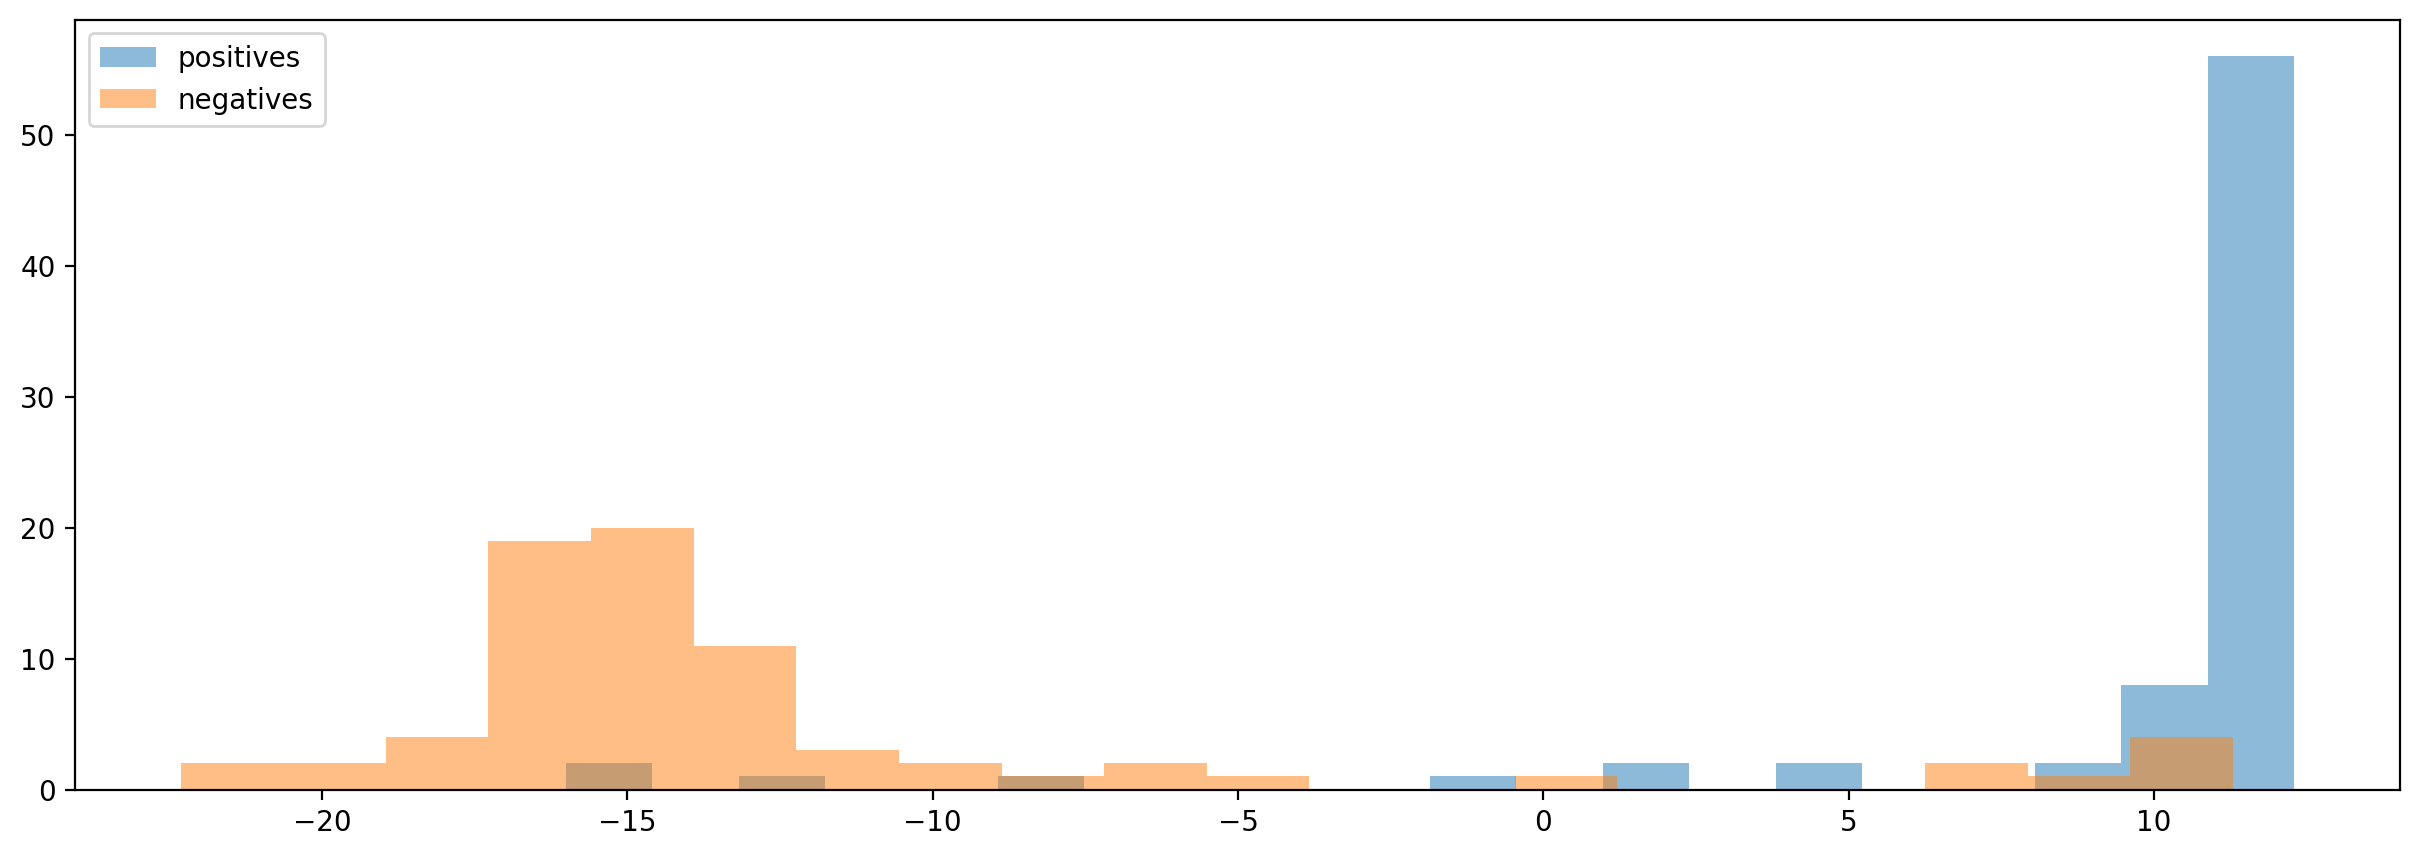

In [180]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_175 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_175

Training size 200

In [181]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [182]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [183]:
emb_train_200 = model.embed(labels_trains['train_size_200'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/13 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [184]:
emb_train_200 = torch.tensor(emb_train_200, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_200.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_200 = emb_train_200.view(emb_train_200.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_200: {emb_train_200.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([400, 512])
Reshaped emb_train_200: torch.Size([400, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [185]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [186]:
emb_train_200 = emb_train_200.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [187]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [188]:
quick_fit(model.network, emb_train_200, labels_trains['train_size_200'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 7.13296903995797e-05, Val Loss: 0.4483084976673126
val AU ROC: 0.956
val MAP: 0.956
Epoch 200/1000, Loss: 4.108373468625359e-05, Val Loss: 0.4743287265300751
val AU ROC: 0.960
val MAP: 0.960
Epoch 300/1000, Loss: 2.906760710175149e-05, Val Loss: 0.4884927272796631
val AU ROC: 0.959
val MAP: 0.959
Epoch 400/1000, Loss: 2.25691546802409e-05, Val Loss: 0.49980270862579346
val AU ROC: 0.959
val MAP: 0.959
Epoch 500/1000, Loss: 1.8203047147835605e-05, Val Loss: 0.510457456111908
val AU ROC: 0.960
val MAP: 0.960
Epoch 600/1000, Loss: 1.5032345800136682e-05, Val Loss: 0.5178806781768799
val AU ROC: 0.962
val MAP: 0.962
Epoch 700/1000, Loss: 1.2630829587578773e-05, Val Loss: 0.5256127715110779
val AU ROC: 0.962
val MAP: 0.962
Epoch 800/1000, Loss: 1.0776589988381602e-05, Val Loss: 0.5325927138328552
val AU ROC: 0.961
val MAP: 0.961
Epoch 900/1000, Loss: 9.294441042584367e-06, Val Loss: 0.5389326214790344
val AU ROC: 0.960
val MAP: 0.960
Epoch 1000/1000, Loss: 8.0916042861

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/1978695488.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9678222222222223

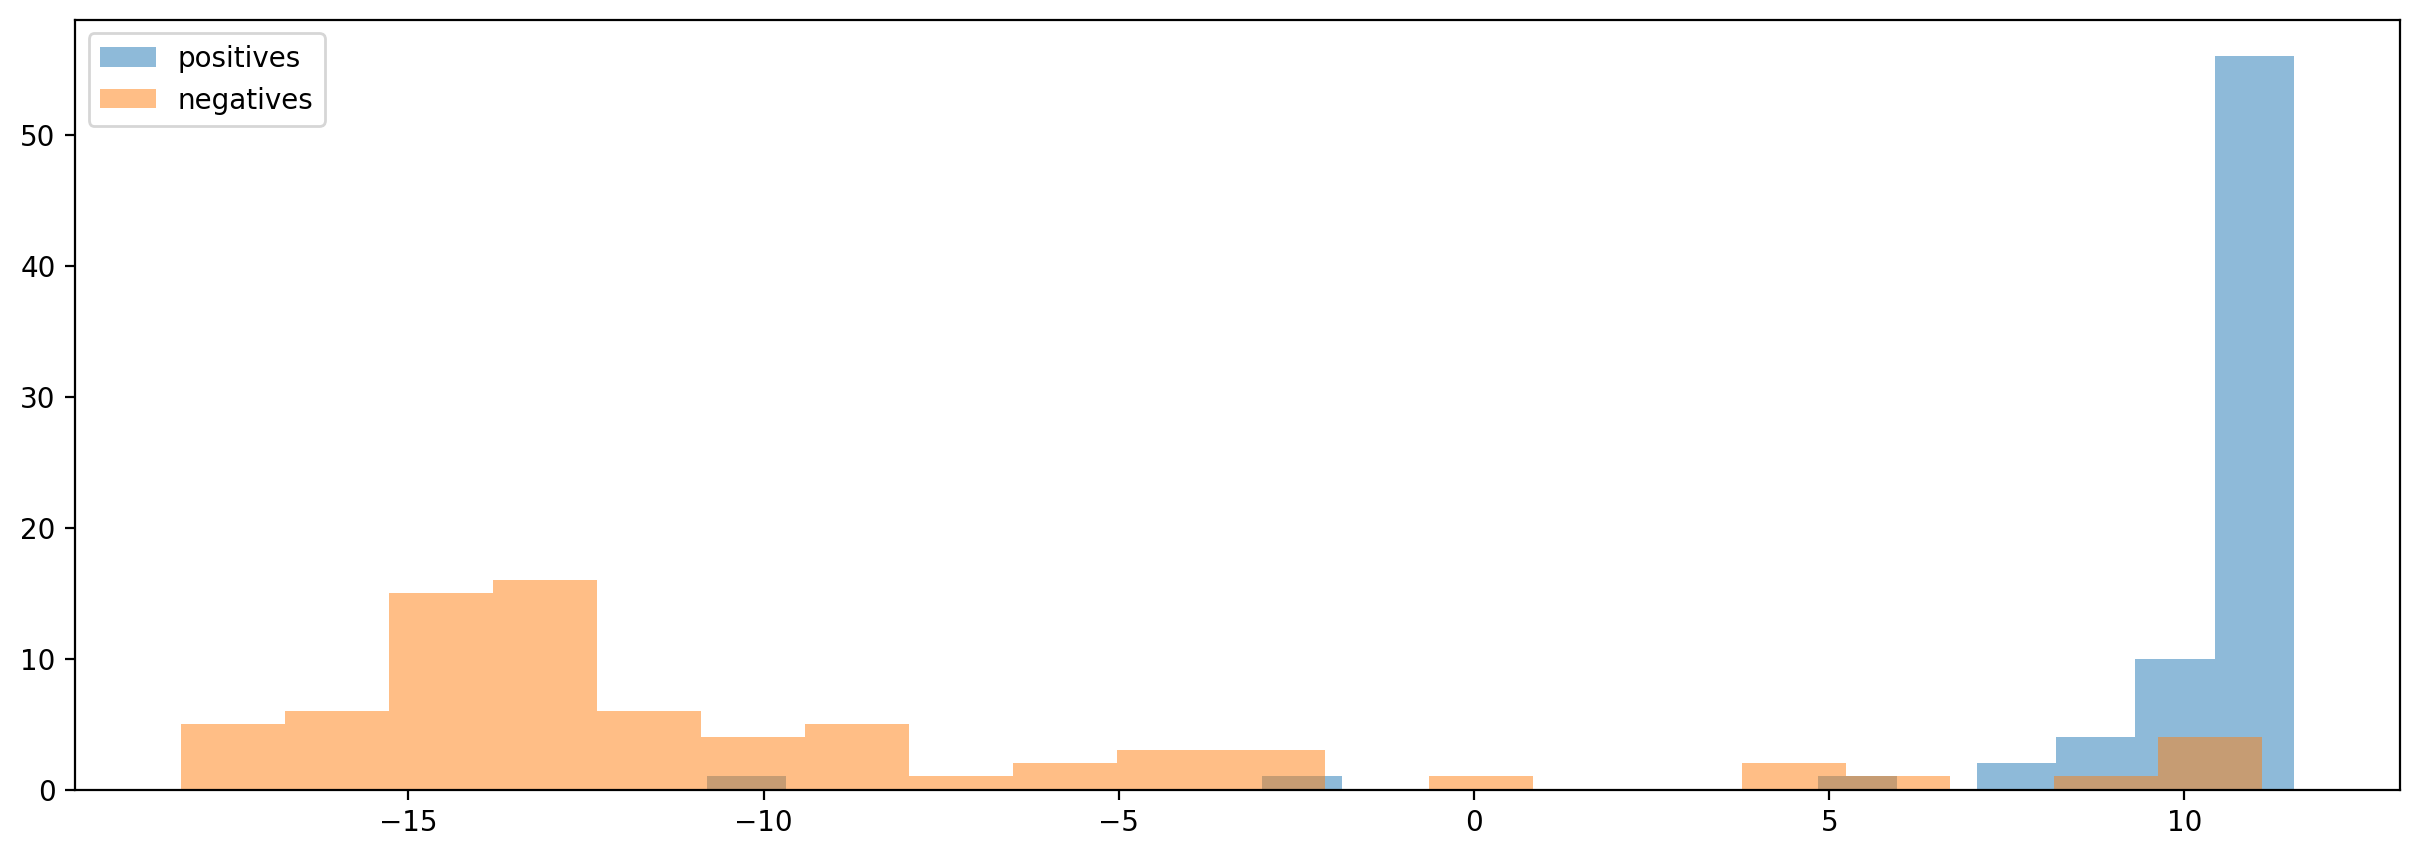

In [189]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_200 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_200

Training size 225

In [190]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [191]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [192]:
emb_train_225 = model.embed(labels_trains['train_size_225'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/15 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [193]:
emb_train_225 = torch.tensor(emb_train_225, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_225.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_225 = emb_train_225.view(emb_train_225.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_225: {emb_train_225.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([450, 512])
Reshaped emb_train_225: torch.Size([450, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [194]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [195]:
emb_train_225 = emb_train_225.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [196]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [197]:
quick_fit(model.network, emb_train_225, labels_trains['train_size_225'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


KeyboardInterrupt: 

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/1751666026.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.8688

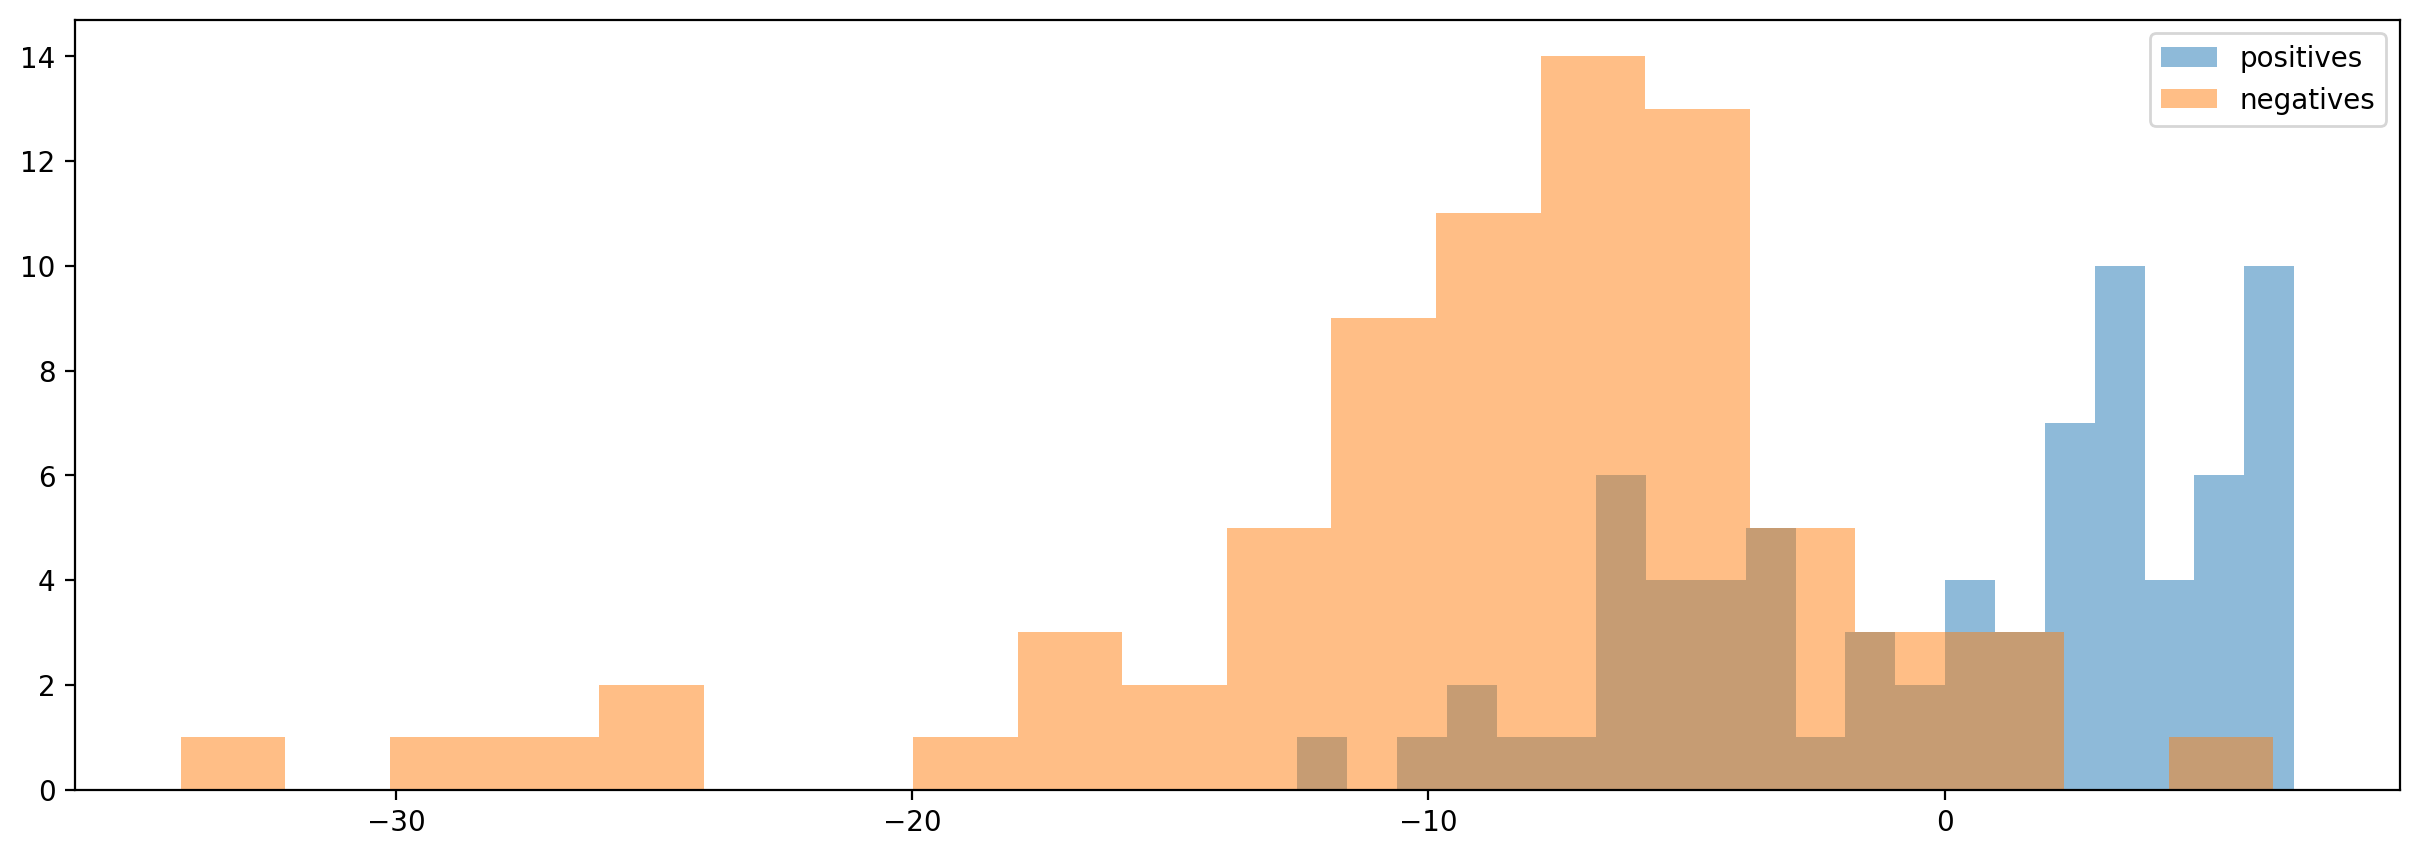

In [ ]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_225 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_225

Training size 250

In [ ]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [ ]:
emb_train_250 = model.embed(labels_trains['train_size_250'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [ ]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
emb_train_250 = torch.tensor(emb_train_250, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_250.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_250 = emb_train_250.view(emb_train_250.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_250: {emb_train_250.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([500, 512])
Reshaped emb_train_250: torch.Size([500, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [ ]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [ ]:
emb_train_250 = emb_train_250.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [ ]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [ ]:
quick_fit(model.network, emb_train_250, labels_trains['train_size_250'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


KeyboardInterrupt: 

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/3342173857.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9399111111111113

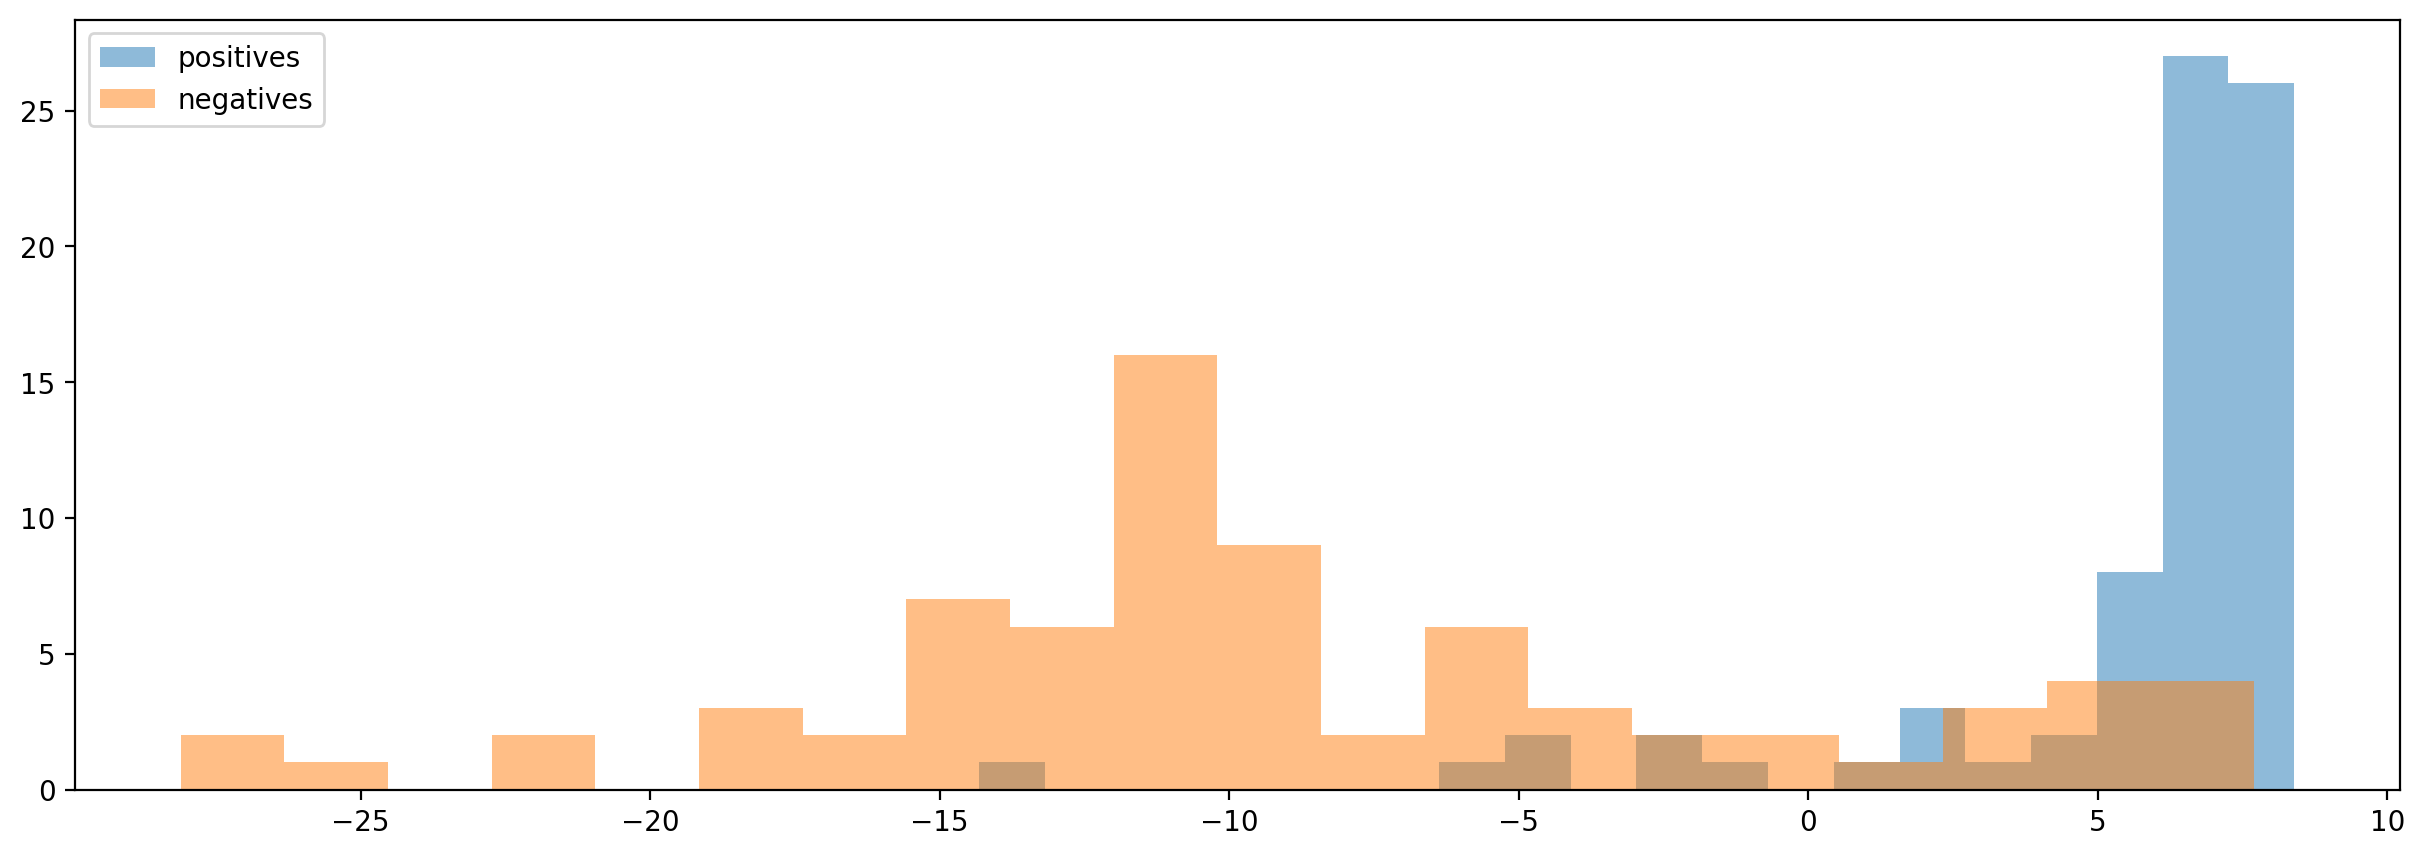

In [ ]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_250 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_250

Training size 275

In [ ]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [ ]:
emb_train_275 = model.embed(labels_trains['train_size_275'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/18 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [ ]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
emb_train_275 = torch.tensor(emb_train_275, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_275.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_275 = emb_train_275.view(emb_train_275.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_275: {emb_train_275.shape}")


Original shape of emb_train: torch.Size([550, 512])
Reshaped emb_train_275: torch.Size([550, 1, 32, 16])


In [ ]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [ ]:
emb_train_275 = emb_train_275.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [ ]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [ ]:
quick_fit(model.network, emb_train_275, labels_trains['train_size_275'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


KeyboardInterrupt: 

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/872787565.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.8492444444444445

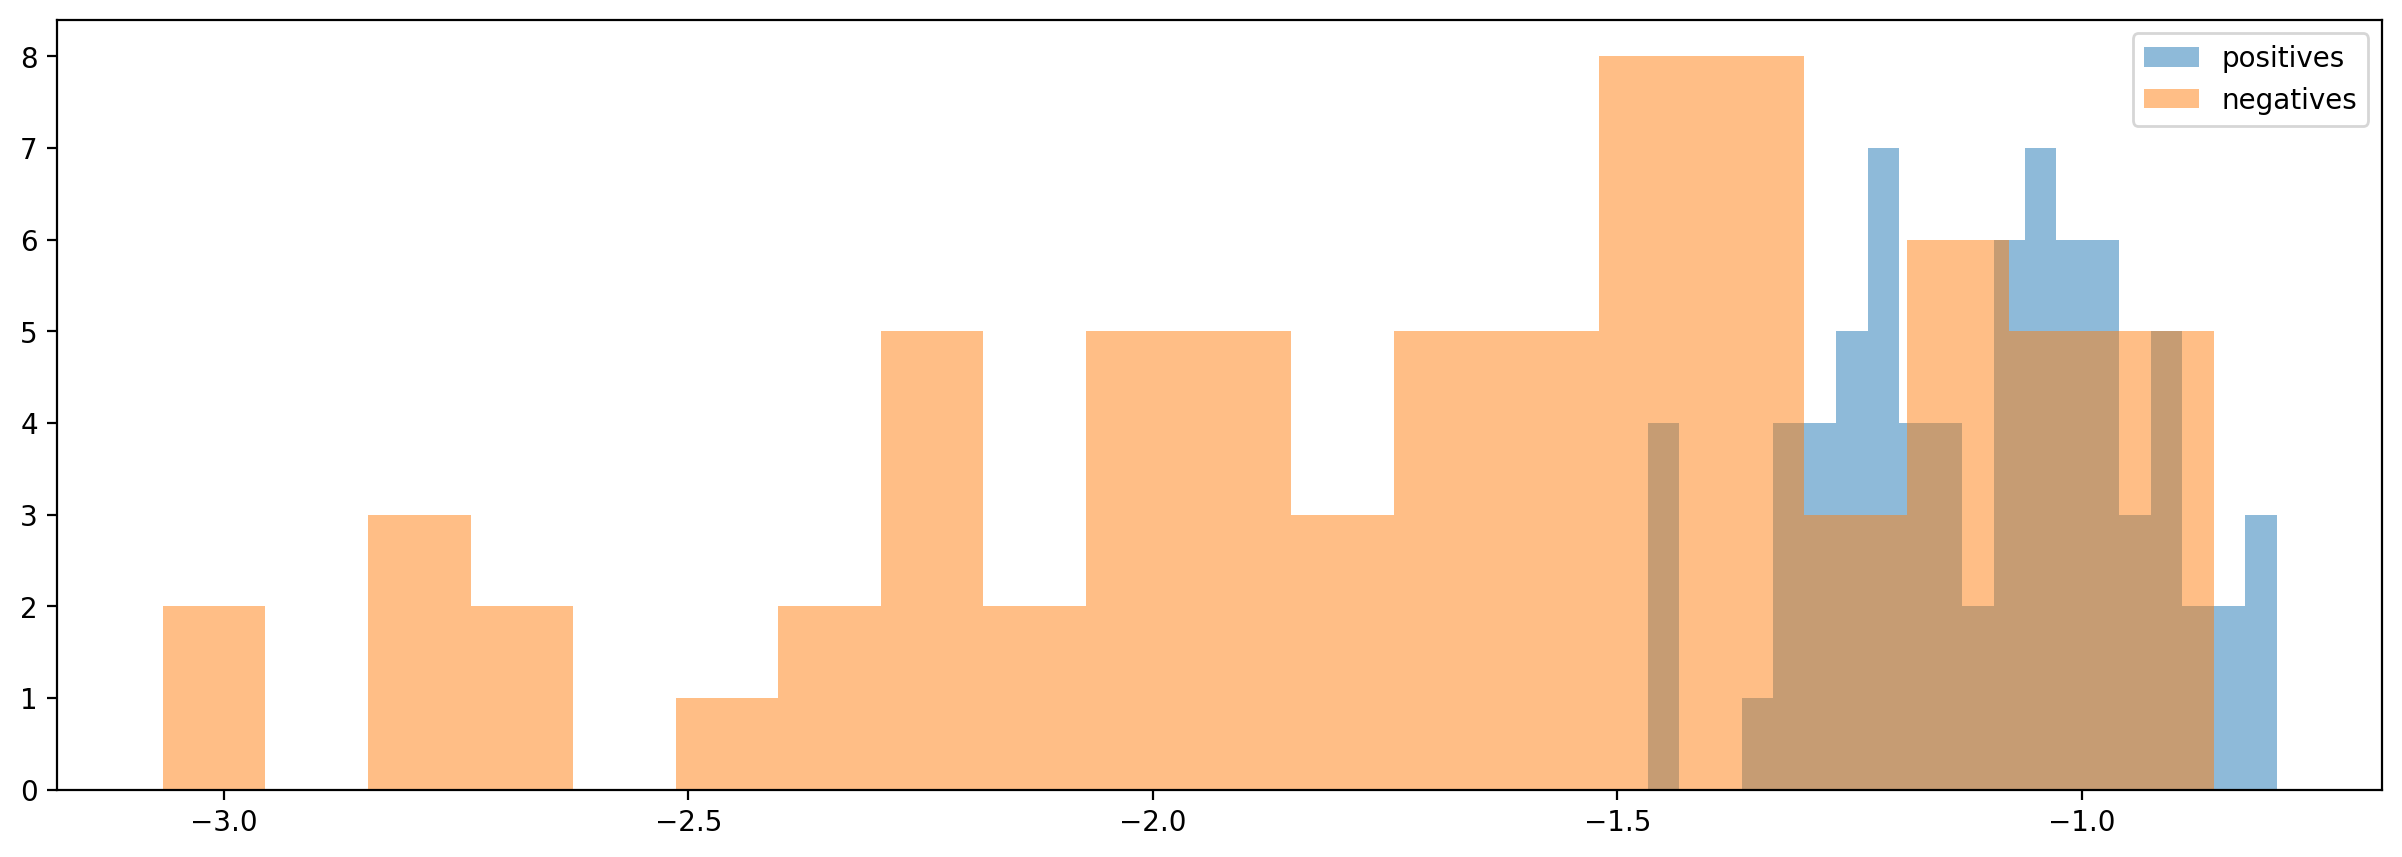

In [ ]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_275 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_275

Training size 300

In [ ]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [ ]:
emb_train_300 = model.embed(labels_trains['train_size_300'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/19 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [ ]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
emb_train_300 = torch.tensor(emb_train_300, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_300.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_300 = emb_train_300.view(emb_train_300.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_300: {emb_train_300.shape}")


Original shape of emb_train: torch.Size([600, 512])
Reshaped emb_train_300: torch.Size([600, 1, 32, 16])


In [ ]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [ ]:
emb_val = emb_val.repeat(1, 3, 1, 1)
emb_train_300 = emb_train_300.repeat(1, 3, 1, 1) 

In [ ]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [ ]:
quick_fit(model.network, emb_train_300, labels_trains['train_size_300'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


KeyboardInterrupt: 

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_91761/3752346880.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.7615999999999999

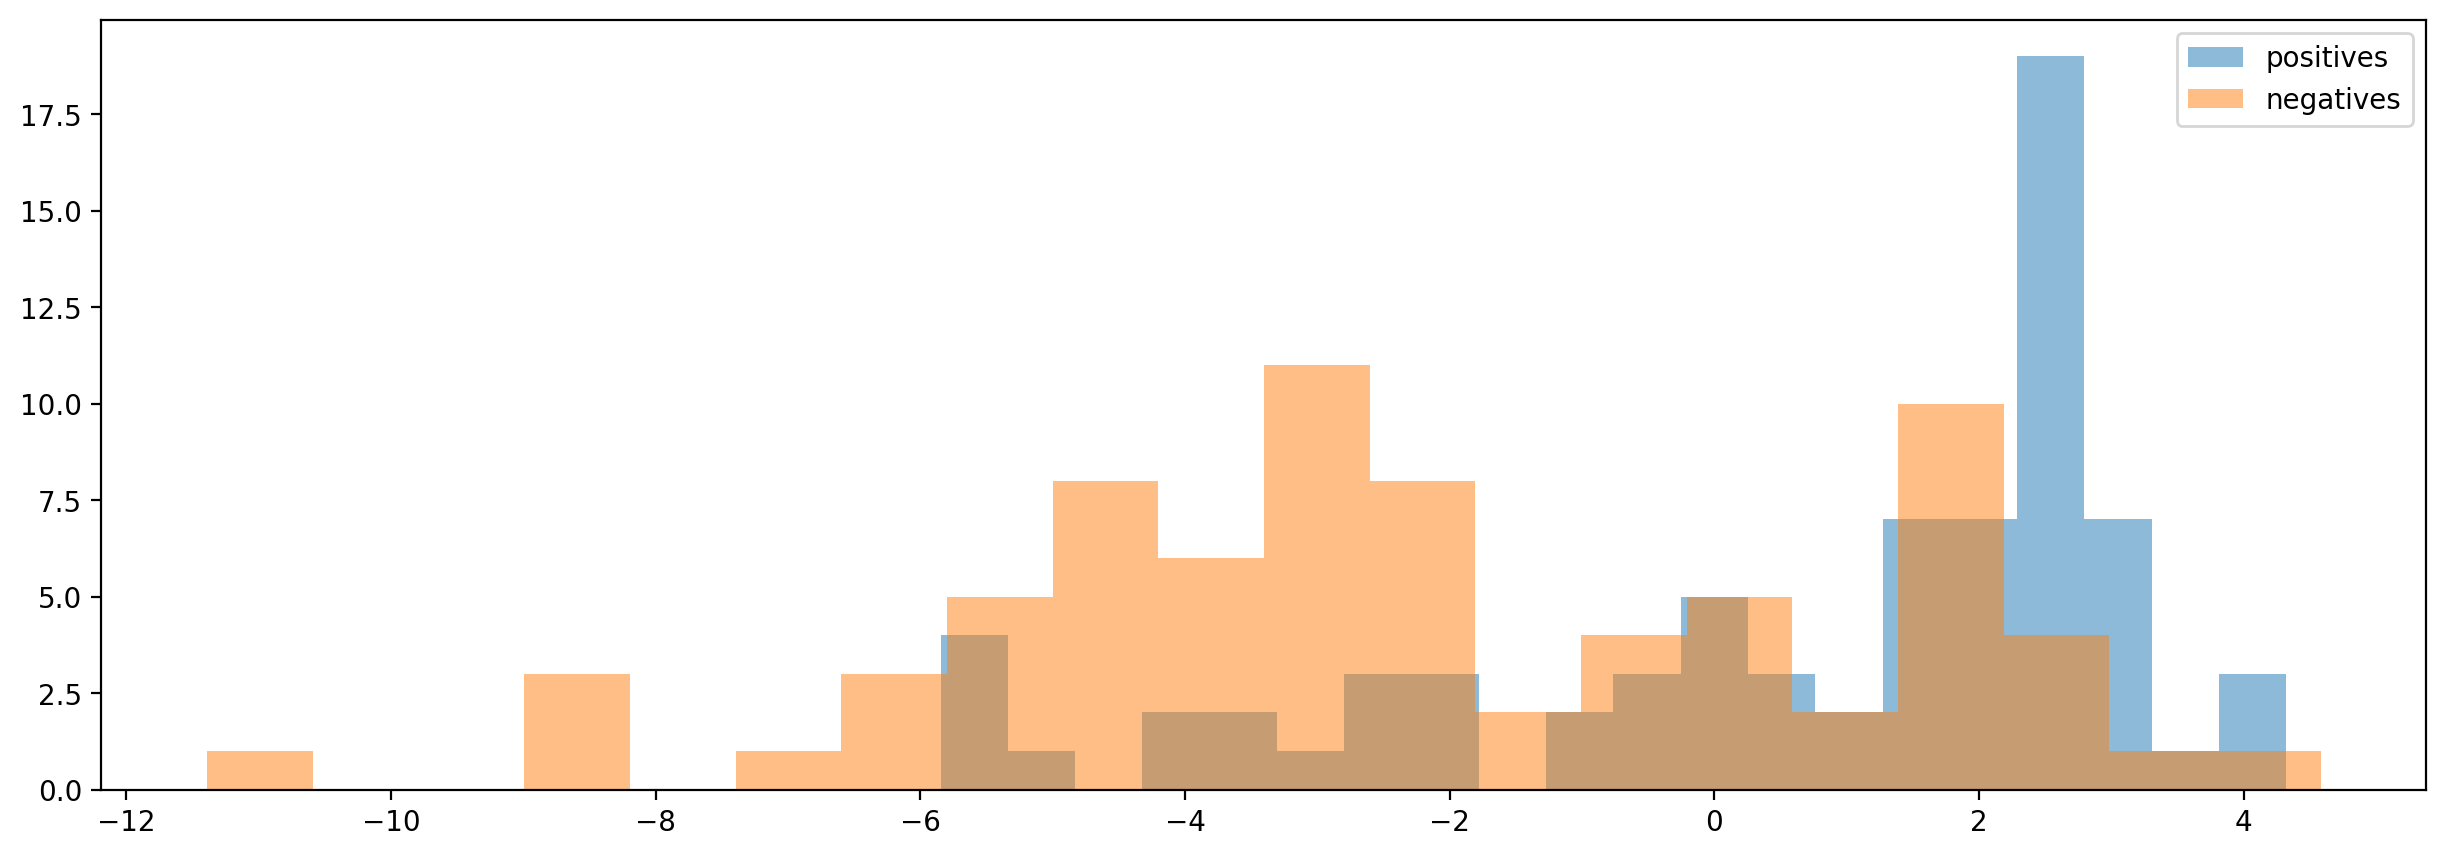

In [ ]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_300 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_300

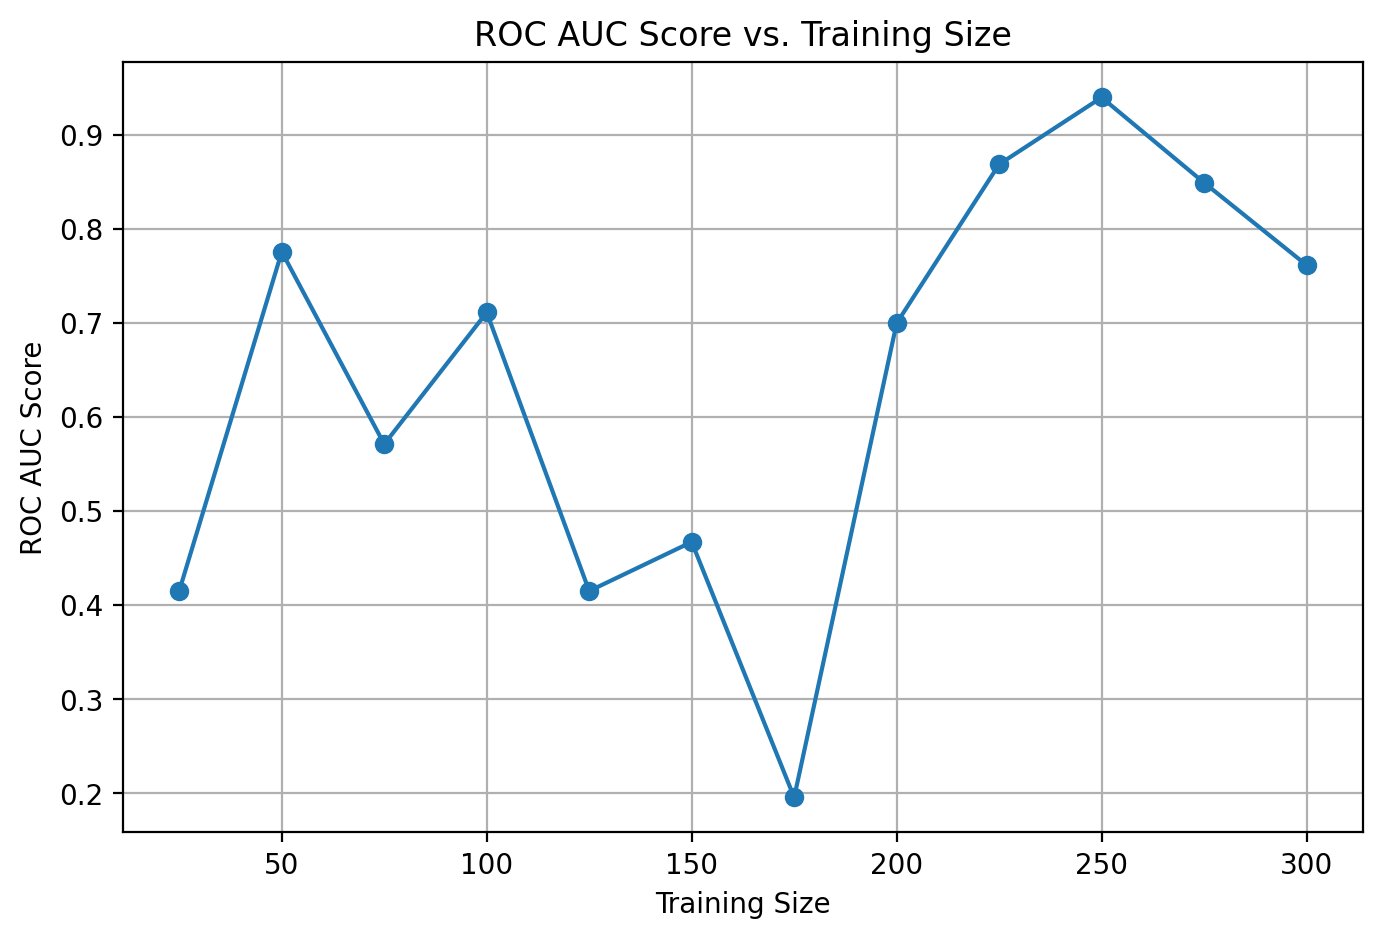

In [ ]:
training_sizes = []
roc_auc_scores = []

# Iterate over training sizes and collect the scores
for size in range(25, 301, 25):
    score = eval(f"roc_auc_score_{size}")
    training_sizes.append(size)
    roc_auc_scores.append(score)

# Create a DataFrame
df = pd.DataFrame({"Training Size": training_sizes, "ROC AUC Score": roc_auc_scores})


# Plot a line plot
plt.figure(figsize=(8, 5))
plt.plot(df["Training Size"], df["ROC AUC Score"], marker='o', linestyle='-')
plt.title("ROC AUC Score vs. Training Size")
plt.xlabel("Training Size")
plt.ylabel("ROC AUC Score")
plt.grid(True)
plt.show()